由于整体模型并不令人意外的失败（甚至是已经优化过的），我们必须rollback回更小的细节进行研究。

第一个更小的基线是，四个可观测变量分别直接建立四个模型（三个泊松一个正态），看看什么结果，是不是本来就是因为数据太多引发的数值错误，
还是那个精妙（坑爹）的一系列分类处理导致的问题。如果实在不行的话直接用拟合边缘分布的方法往回拟合回去。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import theano.tensor as tt


In [2]:
import pickle
with open('cache_dict_float32','rb') as f:
    cache_dict_float32 = pickle.load(f)
    
stage_list = cache_dict_float32['stage_list_float32']
time_length_list = cache_dict_float32['time_length_list']
latent_scen_4_meansd = cache_dict_float32['latent_scen_4_meansd']

stage_list[0].dtype

dtype('float32')

In [3]:
stage = stage_list[0] 

In [4]:
stage.shape # stage 1 obs

(202, 4, 193)

In [5]:
meansd = np.array(latent_scen_4_meansd[0],dtype='float32') # stage 1 
time_length = np.array(time_length_list[0],dtype='float32') # stage 1

In [6]:
meansd.shape # stage 1 5 peroid,5 hp mean and sd

(5, 5, 2)

In [7]:
time_length.shape # stage 1 4 duration mean and sd

(4, 2)

In [8]:
period_num = meansd.shape[0] # in stage 1 -> 5
var_num = meansd.shape[1] # always 5
durations_num = time_length.shape[0] # in stage 1 -> 4
assert time_length.shape[0] == period_num - 1
replay_num = stage.shape[0] # obs

In [9]:
emu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
esd = np.array([stage[:,0,:80].std(),stage[:,0,80:131].std(),stage[:,0,131:].std()],dtype='float32')
emu

array([ 21.84028435,  40.84634018,   5.01133823], dtype=float32)

In [10]:
%%time
import pymc3 as pm
from pymc3 import Normal,Poisson,Deterministic
from pymc3.math import switch,where

Wall time: 10.2 s


首先建立pressing_shift的单独的模型。

In [13]:
model = pm.Model()

In [14]:
%%time
with model:
    mu = Normal('mu',mu=0,sd=1)
    sd = pm.HalfNormal('sd',sd=1)
    pressing_shift = Normal('pressing_shift',mu,sd,observed = stage[:,0,:])
    
    trace = pm.sample(1000)

100%|█████████████████████████████████████| 1000/1000 [00:09<00:00, 109.87it/s]


Wall time: 2min 17s


上面是带了变分推断初始化的版本，变分推断本身浪费了很多时间
（advi那个推断主要就是给每个非观测随机变量一个（边缘）均值一个（边缘）标准差的估计罢了，对MCMC可能可以省掉burnin阶段，
但也可能迭代个200k次（默认情况）效果就相当于个位数的MCMC）

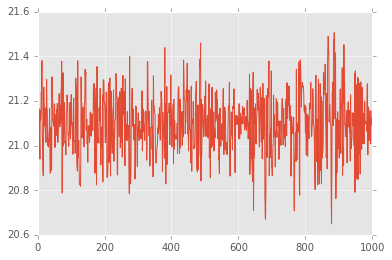

In [16]:
plt.plot(trace['mu'])

In [18]:
stage[:,0,:].mean()

21.456421

In [21]:
model2 = pm.Model()

In [23]:
%%time
with model2:
    mu = Normal('mu',mu=0,sd=1)
    sd = pm.HalfNormal('sd',sd=1)
    pressing_shift = Normal('pressing_shift',mu,sd,observed = stage[:,0,:])
    
    trace2 = pm.sample(1000,init=None)

100%|█████████████████████████████████████| 1000/1000 [00:09<00:00, 101.40it/s]


Wall time: 28.8 s


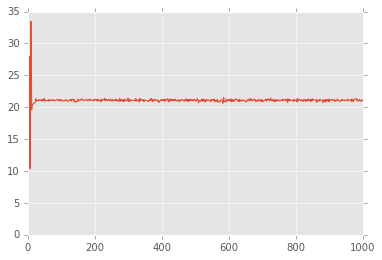

In [26]:
plt.plot(trace2['mu'])

In [ ]:
plt.plot(trace4['mu'])

当然，这个pressing_shift我之前指定的是个泊松模型。。给忘了。

In [29]:
model3 = pm.Model()

In [31]:
%%time
with model3:
    mu = pm.HalfNormal('mu',sd=1)
    pressing_shift = Poisson('pressing_shift',mu,observed = stage[:,0,:])
    
    trace3 = pm.sample(1000,init=None)

100%|█████████████████████████████████████| 1000/1000 [00:06<00:00, 226.30it/s]


Wall time: 44 s


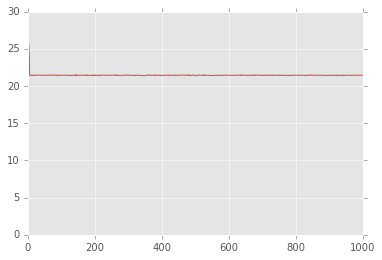

In [32]:
plt.plot(trace3['mu'])

In [33]:
model4 = pm.Model()

In [34]:
%%time
with model4:
    mu = pm.HalfNormal('mu',sd=1,testval=stage[:,0,:].mean())
    pressing_shift = Poisson('pressing_shift',mu,observed = stage[:,0,:])
    
    trace4 = pm.sample(1000,init=None)

100%|█████████████████████████████████████| 1000/1000 [00:05<00:00, 168.82it/s]


Wall time: 9.54 s


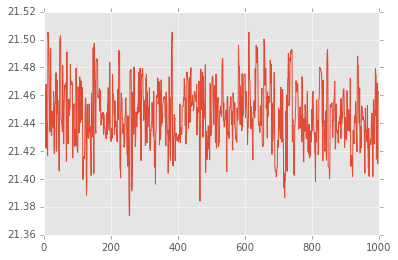

In [35]:
plt.plot(trace4['mu'])

看起来一切都在意料之中，数据大小并不是问题所在之处。那么我们再分别来看看单独处理pressing_shift变量分为三个或五个不同的参数时，
那种where矩阵技巧是否带来了问题。

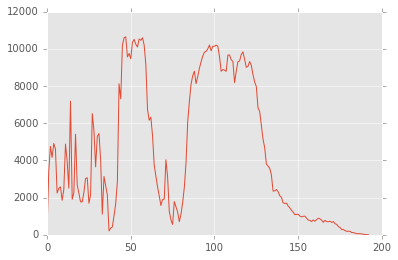

In [39]:
plt.plot(stage[:,0,:].sum(axis=0))

In [40]:
time_length

array([[ 80.,   3.],
       [  4.,   1.],
       [ 47.,  10.],
       [  4.,   1.]], dtype=float32)

In [44]:
stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()

(21.840284, 40.84634, 5.0113382)

我们就当做这三个区间上的区别是真实的（相比原模型不但抹去了其他变量还抹去了对话时间）。看看那个坑爹写法是否能捕捉（是不是有bug）

In [10]:
emu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
esd = np.array([stage[:,0,:80].std(),stage[:,0,80:131].std(),stage[:,0,131:].std()],dtype='float32')

In [11]:
model = pm.Model()

In [12]:
%%time
with model:
    # 这里设定stage 1 里5个阶段对应的前4个阶段的持续时间，然后定义断点为持续时间的函数
    # 虽然这个变量不应该是伪随机变量或随机参数，而是隐变量，所以每个replay应该对应一个向量实现，这是第一次用上replay数量信息（之前就搞错了。。）
    durations = Normal('durations', mu = np.array([80,131],dtype='float32'), sd = np.array([3,10],dtype='float32'), shape = (202, 2))
    breaks = tt.cumsum(durations, axis=1) # 202 * 4 matrix 
    Deterministic('breaks', breaks)

Wall time: 16.8 s


In [13]:
stage_length = stage.shape[2]
time_axis = np.arange(stage_length)

_time_axis = np.tile(time_axis,(202, 2, 1)) # add batch...
_time_axis.shape

(202, 2, 193)

In [14]:
%%time
with model:
    # 这里定义出193个时间步到底属于哪个类，这是个大坑，之前居然没想到where(x > y,1,0)之类的方法把逻辑值转成01真是脑残了。。
    _breaks = tt.transpose(tt.tile(breaks,(stage_length, 1, 1)),[1,2,0]) # 高维转置。。看的都头大，和单向量情况还不一样，醉了。。
    _mask =  pm.math.where(_time_axis > _breaks, 1, 0) # 
    index = pm.Deterministic('index', tt.sum(_mask, axis=1)) # 202 * 193 matrix

Wall time: 478 ms


In [16]:
%%time
with model:
    # 直接钦定pressing_shift对应的lam参数的先验分布的两个参数
    mu = pm.Exponential('mu', lam = 1/emu, shape=3) # 之前忘了保证它是正的了，这个要在最上面那种简单模型里可以直接报错的。

Wall time: 7.53 s


In [17]:
%%time
with model:
    time_mu_list = []
    for i in range(202):
        time_mu_list.append(mu[index[i]])
    time_mu = pm.math.stack(time_mu_list) # 202 * 193 matrix
    pressing_shift = Poisson('pressing_shift', mu = time_mu, observed = stage[:,0,:]) # 202 * 193 matrix

Wall time: 925 ms


In [20]:
with model:
    # go on?..
    trace = pm.sample(200, init=None, n_init =0)

  4%|█▋                                        | 8/200 [00:20<08:00,  2.50s/it]

Wall time: 6min 37s


In [21]:
trace['mu']

array([[ 15.13853068,  28.3125281 ,   3.4735948 ],
       [ 15.13853068,  28.3125281 ,   3.4735948 ],
       [ 15.13853068,  28.3125281 ,   3.4735948 ],
       [ 15.13853068,  28.3125281 ,   3.4735948 ],
       [ 15.13853068,  28.3125281 ,   3.4735948 ],
       [ 15.13853068,  28.3125281 ,   3.4735948 ],
       [ 15.13853068,  28.3125281 ,   3.4735948 ],
       [ 15.13853068,  28.3125281 ,   3.4735948 ]])

In [22]:
with model:
    trace = pm.sample(200,trace=trace)


  2%|▊                                       | 4/200 [02:38<2:34:48, 47.39s/it]

看起来出于某种神秘的原因，算法老是在走了头几步后就卡住了，让我们把模型退化回只有一个replay，然后直接硬编码switch与where看看错误还存不存在。

In [27]:
sds = emu * np.sqrt(np.pi/2)
obs_l = []

In [31]:
model = pm.Model()

In [32]:
%%time
with model:
    # 这里设定stage 1 里5个阶段对应的前4个阶段的持续时间，然后定义断点为持续时间的函数
    # 虽然这个变量不应该是伪随机变量或随机参数，而是隐变量，所以每个replay应该对应一个向量实现，这是第一次用上replay数量信息（之前就搞错了。。）
    durations = Normal('durations', mu = np.array([80,131],dtype='float32'), sd = np.array([3,10],dtype='float32'), shape = 2)#fuck,之前没发现这里写错了
    breaks = tt.cumsum(durations, axis=1) # 202 * 4 matrix 
    Deterministic('breaks', breaks)
    
    #直接定义三阶段使用参数的分布为半正态分布， 半正态分布标准差当然是sd，均值是sd*sqrt(2/pi)，所以用均值确定sd要*(pi/2)
    mus = pm.HalfNormal('mus', sd = sds, shape=3)
    
    #直接硬编码一个回放序列,用硬编码的where法
    for i in range(stage.shape[2]):
        pv = Poisson('obs {}'.format(i), mu = where(i < breaks[0], mus[0], where(i < breaks[1], mus[1], mus[2])), observed = stage[0,0,i])
        obs_l.append(pv)


Wall time: 8.83 s


In [35]:
%%time
with model:
    trace = pm.sample(1000, init=None)

KeyboardInterrupt: 

卡了好久啊，有任何理由么。。也就变量数量多了点吧。我看我这论文就要被这些垃圾库坑掉了。稍微用一下不优化（但其他方面优化了200倍好吗。。）的方式就爆了内存，666。

下面试图仍然保持这种嵌套where写法（即不用下标法），但用之前的向量表示优化一下看看行不行。

In [48]:
sds = emu * np.sqrt(np.pi/2)
time_axis = np.arange(stage.shape[2],dtype='float32')

#model = pm.Model()

In [49]:
%%time
with pm.Model() as model:
    # 这里设定stage 1 里5个阶段对应的前4个阶段的持续时间，然后定义断点为持续时间的函数
    # 虽然这个变量不应该是伪随机变量或随机参数，而是隐变量，所以每个replay应该对应一个向量实现，这是第一次用上replay数量信息（之前就搞错了。。）
    durations = Normal('durations', mu = np.array([80,131],dtype='float32'), sd = np.array([3,10],dtype='float32'), shape = 2)
    breaks = tt.cumsum(durations) # length 2 array
    Deterministic('breaks', breaks)
    
    #直接定义三阶段使用参数的分布为半正态分布， 半正态分布标准差当然是sd，均值是sd*sqrt(2/pi)，所以用均值确定sd要*(pi/2)
    mus = pm.HalfNormal('mus', sd = sds, shape=3)
    
    #用向量法硬编码。。我真是要吐血了，真不应该我不熟悉的技术
    
    index_mus = where(time_axis < breaks[0], mus[0], where(time_axis < breaks[1], mus[1], mus[2]))
    #pressing_shift = Poisson('shift', mu=index_mus, observed = stage[0,0,:], shape = stage.shape[2])
    #pressing_shift = Normal('shift', mu=index_mus, sd=index_mus, observed = stage[0,0,:], shape = stage.shape[2])
    pressing_shift = Normal('shift', mu=index_mus, sd=index_mus, observed = stage[0,0,:])

    trace = pm.sample(1000,init=None)

TypeError: expected type_num 1 (NPY_INT8) got 7
Apply node that caused the error: Elemwise{Composite{Switch(i0, ((-((i1 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i7 * i8) + (Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i9))) + (i10 * (((i11 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i7 * i7) / sqr(i9)) - (i12 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i8 * i7))) + (i10 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * (((i13 * Composite{inv(Composite{sqr(sqr(i0))}(i0))}(i14)) / i9) - (i13 * i15 * Composite{inv(Composite{sqr(sqr(i0))}(i0))}(i14))))), i16)}}[(0, 14)](Elemwise{Composite{Identity(GT(i0, i1))}}.0, TensorConstant{(1,) of 2.0}, Elemwise{gt,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{gt,no_inplace}.0, InplaceDimShuffle{x}.0, InplaceDimShuffle{x}.0, Elemwise{Composite{inv(Composite{(sqr(i0) * i0)}(i0))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{inv(sqr(i0))}}.0, TensorConstant{(1,) of -2.0}, TensorConstant{(1,) of 1.0}, TensorConstant{(1,) of -1.0}, TensorConstant{(1,) of -1.5}, Elemwise{Composite{Switch(i0, i1, Switch(i2, i3, i4))}}.0, Elemwise{sqr,no_inplace}.0, TensorConstant{(1,) of 0})
Toposort index: 40
Inputs types: [TensorType(int8, vector), TensorType(float64, (True,)), TensorType(bool, vector), TensorType(float64, (True,)), TensorType(bool, vector), TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, vector), TensorType(float64, vector), TensorType(int8, (True,))]
Inputs shapes: [(193,), (1,), (193,), (1,), (193,), (1,), (1,), (193,), (193,), (193,), (1,), (1,), (1,), (1,), (193,), (193,), (1,)]
Inputs strides: [(4,), (8,), (1,), (8,), (1,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (1,)]
Inputs values: ['not shown', array([ 2.]), 'not shown', array([ 21.84028518]), 'not shown', array([ 0.]), array([ 0.]), 'not shown', 'not shown', 'not shown', array([-2.]), array([ 1.]), array([-1.]), array([-1.5]), 'not shown', 'not shown', array([0], dtype=int8)]
Outputs clients: [[Elemwise{Switch}(Elemwise{gt,no_inplace}.0, Elemwise{Composite{Switch(i0, ((-((i1 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i7 * i8) + (Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i9))) + (i10 * (((i11 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i7 * i7) / sqr(i9)) - (i12 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i8 * i7))) + (i10 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * (((i13 * Composite{inv(Composite{sqr(sqr(i0))}(i0))}(i14)) / i9) - (i13 * i15 * Composite{inv(Composite{sqr(sqr(i0))}(i0))}(i14))))), i16)}}[(0, 14)].0, TensorConstant{(1,) of 0.0}), Elemwise{Switch}[(0, 2)](Elemwise{gt,no_inplace}.0, TensorConstant{(1,) of 0.0}, Elemwise{Composite{Switch(i0, ((-((i1 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i7 * i8) + (Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i9))) + (i10 * (((i11 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i7 * i7) / sqr(i9)) - (i12 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * i8 * i7))) + (i10 * Composite{Switch(i0, i1, Switch(i2, i3, i4))}(i2, i3, i4, i5, i6) * (((i13 * Composite{inv(Composite{sqr(sqr(i0))}(i0))}(i14)) / i9) - (i13 * i15 * Composite{inv(Composite{sqr(sqr(i0))}(i0))}(i14))))), i16)}}[(0, 14)].0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [73]:
%%time
with pm.Model() as model:
    # 这里设定stage 1 里5个阶段对应的前4个阶段的持续时间，然后定义断点为持续时间的函数
    # 虽然这个变量不应该是伪随机变量或随机参数，而是隐变量，所以每个replay应该对应一个向量实现，这是第一次用上replay数量信息（之前就搞错了。。）
    durations = Normal('durations', mu = np.array([80,51],dtype='float32'), sd = np.array([3,10],dtype='float32'), shape = 2)
    breaks = tt.cumsum(durations) # length 2 array
    Deterministic('breaks', breaks)
    
    #直接定义三阶段使用参数的分布为半正态分布， 半正态分布标准差当然是sd，均值是sd*sqrt(2/pi)，所以用均值确定sd要*(pi/2)
    mus = pm.HalfNormal('mus', sd = sds, shape=3)
    
    
    #用向量法硬编码。。我真是要吐血了，真不应该我不熟悉的技术
    
    #index_mus = where(time_axis < breaks[0], mus[0], where(time_axis < breaks[1], mus[1], mus[2]))
    
    #index_mus = Deterministic('index_mus', where(time_axis < breaks[0], mus[0], where(time_axis < breaks[1], mus[1], mus[2])))
    #index_mus = Deterministic('index_mus', where(time_axis < breaks[0], mus[0], mus[1]))
    index_mus = Deterministic('index_mus', switch(Normal('N1',mu=0,sd=1) < Normal('N2',mu=0,sd=1), mus[0], mus[1]))
    
    #pressing_shift = Poisson('shift', mu=index_mus, observed = stage[0,0,:], shape = stage.shape[2])
    #pressing_shift = Normal('shift', mu=index_mus, sd=index_mus, observed = stage[0,0,:], shape = stage.shape[2])
    #pressing_shift = Normal('shift', mu=index_mus, sd=index_mus, observed = stage[0,0,:])
    pressing_shift = Normal('shift', mu=index_mus, sd=index_mus, shape=stage.shape[2],observed=stage[0,0,:])

    trace = pm.sample(250,init=None)

  3%|█▎                                        | 8/250 [00:29<26:07,  6.48s/it]

Wall time: 2min 21s


In [71]:
trace['index_mus']

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [56]:
trace['index_mus'][-1]

array([  0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54629939,
         0.54629939,   0.54629939,   0.54629939,   0.54

In [34]:
%%time
with pm.Model() as model:
    # 这里设定stage 1 里5个阶段对应的前4个阶段的持续时间，然后定义断点为持续时间的函数
    # 虽然这个变量不应该是伪随机变量或随机参数，而是隐变量，所以每个replay应该对应一个向量实现，这是第一次用上replay数量信息（之前就搞错了。。）
    durations = Normal('durations', mu = np.array([80,51],dtype='float32'), sd = np.array([3,10],dtype='float32'), shape = 2)
    breaks = tt.cumsum(durations) # length 2 array
    Deterministic('breaks', breaks)
    
    #直接定义三阶段使用参数的分布为半正态分布， 半正态分布标准差当然是sd，均值是sd*sqrt(2/pi)，所以用均值确定sd要*(pi/2)
    mus = pm.HalfNormal('mus', sd = sds, shape=3)
    
    index_mus = Deterministic('index_mus', where(time_axis < breaks[0], mus[0], where(time_axis < breaks[1], mus[1], mus[2])))
    
    trace = pm.sample(1000,init=None)



100%|█████████████████████████████████████| 1000/1000 [00:04<00:00, 244.67it/s]


Wall time: 7.29 s


In [35]:
trace['breaks'][-5:]

array([[  77.58787357,  134.1153036 ],
       [  82.46769442,  128.27900482],
       [  76.77766747,  135.76451949],
       [  73.38406361,  116.43299291],
       [  73.38406361,  116.43299291]])

In [36]:
trace['index_mus'][-1]

array([  6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24809668,
         6.24809668,   6.24809668,   6.24809668,   6.24

In [37]:
len(_)

193

In [38]:
stage.shape[2]

193

In [43]:
import pymc3 as pm
with pm.Model():
    pm.Poisson("pois", 10)
    trace = pm.sample(1000, step=pm.Metropolis())




  0%|                                                 | 0/1000 [00:00<?, ?it/s]

 77%|████████████████████████████▍        | 768/1000 [00:00<00:00, 7633.81it/s]

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 7961.38it/s]